In [1]:
import sys
sys.path.append('../../')

In [2]:
from SynRBL.rsmi_utils import load_database, save_database

art1 = load_database('../../Data/Validation_set/artificial_data_1/mcs_based_reactions.json.gz')
art2 = load_database('../../Data/Validation_set/artificial_data_2/mcs_based_reactions.json.gz')

In [ ]:
golden = load_database('../../Data/Validation_set/golden_dataset/rule_based_reactions.json.gz')

In [ ]:
list_wrong = [11,213, 234, 221, 225, 227, 233, 239, 240, 241, 242, 249, 270, 273, 283, 366, 374, 375, 444, 449, 481, 635, 663]

In [ ]:
len(list_wrong)

In [ ]:
golden_wrong = [golden[i] for i in list_wrong]

In [ ]:
golden

In [ ]:
ground_truth

In [ ]:
ground_truth = golden.copy()

In [ ]:
import pandas as pd
ground_truth = pd.DataFrame(ground_truth)[['R-id', 'reactions']].to_dict(orient='records')

In [ ]:
ground_truth[630]['reactions'] = number_630
vis.plot_reactions(ground_truth[630], 'reactions', 'reactions', compare=False, savefig=False)

In [ ]:
# wrong reaction fix


number_444 = '[CH:17]=1[CH:18]=[CH:19][C:14](=[CH:15][CH:16]=1)[CH:12]([OH:13])[CH2:11][CH2:10][CH2:9][CH2:8][CH2:7][CH2:6][CH2:5][CH2:4][CH2:3][CH3:2].[OH-:1]>>[CH:17]=1[CH:18]=[CH:19][C:14](=[CH:15][CH:16]=1)[CH:12]([OH:13])[CH2:11][CH2:10][CH2:9][CH2:8][CH2:7][CH2:6][CH2:5][CH2:4][CH2:3][CH3:2].[OH-:1]'

number_449 = '[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][Br:6].[Mg:7]>>[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][Mg:7][Br:6]'

number_481  = '[CH:6]=1[CH:7]=[CH:8][CH:9]=[CH:10][C:5]=1[CH3:4].[O-:3][N+:2](=[O:1])[OH:11]>>[N+:2]([O-:3])(=[O:1])[C:8]1=[CH:7][CH:6]=[C:5]([CH3:4])[CH:10]=[CH:9]1.[OH:12]'


number_663 = '[CH:12]1=[C:11]([CH2:10][N:9]([CH2:17][C:18]2=[CH:19][CH:20]=[CH:21][CH:22]=[CH:23]2)[C:8]=3[CH:24]=[CH:25][CH:26]=[C:6]([CH:7]=3)[Br:29])[CH:16]=[CH:15][CH:14]=[CH:13]1.[CH2:3]1[CH2:4][CH2:5][CH:1]([CH2:2]1)[Br:27].[Mg:28]>>[CH2:2]1[CH2:3][CH2:4][CH2:5][CH:1]1[C:6]=2[CH:26]=[CH:25][CH:24]=[C:8]([CH:7]=2)[N:9]([CH2:17][C:18]=3[CH:19]=[CH:20][CH:21]=[CH:22][CH:23]=3)[CH2:10][C:11]=4[CH:16]=[CH:15][CH:14]=[CH:13][CH:12]=4.[Br:27][Mg:28][Br:29]'



In [ ]:
# wrong reaction rule based


number_621 ='[C:3](=[O:5])([CH2:2][CH3:1])[CH3:4].[NH2:8][N:7]([CH3:6])[C:9]1=[CH:10][CH:11]=[CH:12][CH:13]=[CH:14]1>>[CH:11]=1[CH:12]=[CH:13][CH:14]=[C:9]2[C:10]=1[C:2]([CH3:1])=[C:3]([CH3:4])[N:7]2[CH3:6].[NH3:8].[OH2:5]'

number_630 = '[CH2:7]([CH2:8][OH:9])[CH3:6].[Cl:1][C:2]([Cl:3])([Cl:4])[Cl:5].[CH:11]1=[CH:12][CH:13]=[CH:14][CH:15]=[C:16]1[P:10]([C:17]2=[CH:18][CH:19]=[CH:20][CH:21]=[CH:22]2)[C:23]1=[CH:24][CH:25]=[CH:26][CH:27]=[C:28]1>>[CH2:7]([CH3:6])[CH2:8][Cl:5].[Cl:1][CH:2]([Cl:3])[Cl:4].[CH:11]1=[CH:12][CH:13]=[CH:14][CH:15]=[C:16]1[P:10](=[O:5])([C:17]2=[CH:18][CH:19]=[CH:20][CH:21]=[CH:22]2)[C:23]1=[CH:24][CH:25]=[CH:26][CH:27]=[C:28]1'

In [10]:

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdChemReactions as Reactions
from rdkit.Chem.Draw import IPythonConsole
from PIL import Image

display(Reactions.ReactionFromSmarts(number_283, useSmiles=True))

vis.plot_reactions(golden[283], 'reactions', 'new_reaction', compare=True, show_atom_numbers=False)


NameError: name 'number_283' is not defined

In [ ]:
golden[621]['reactions']

In [ ]:
from SynRBL.SynChemImputer.appel_reaction import AppelReaction

appel = AppelReaction()


In [ ]:
golden[283]['reactions']

In [ ]:
Chem.MolFromSmiles('[C-:26]#[O+:27]')

In [ ]:
test ='[C-:26]#[O+:27].[CH3:19][C:18]([CH3:20])([CH3:21])[Si:15]([CH3:16])([CH3:17])[O:14][CH2:13][CH2:12][CH:11]1[CH:10]2[CH:1]([CH:25]=[CH:24][CH:22]1[OH:23])[CH2:2][CH2:3][N:4]2[C:5](=[O:6])[O:7][CH2:8][CH3:9].[NH3:27]>>[CH3:19][C:18]([CH3:20])([CH3:21])[Si:15]([CH3:16])([CH3:17])[O:14][CH2:13][CH2:12][CH:11]1[CH:22]=[CH:24][CH:25]([CH:1]2[CH2:2][CH2:3][N:4]([C:5](=[O:6])[O:7][CH2:8][CH3:9])[CH:10]12)[C:26](=[O:27])[NH2:27].[OH2:23]'

In [ ]:
vis.plot_reactions(golden[283], 'reactions', 'new_reaction', compare=True, show_atom_numbers=False)

In [348]:
save_database(ground_truth, '../../Data/Validation_set/golden_dataset/rule_based_ground_truth.json.gz')

In [ ]:
golden[630]['reactions']

In [ ]:
class AppelReaction:
    TCM = 'ClC(Cl)(Cl)Cl'
    TCM_product = 'ClC(Cl)Cl'
    TBM = 'BrC(Br)(Br)Br'
    TBM_product = 'BrC(Br)Br'
    TPP = 'c1ccccc1P(c2ccccc2)c3ccccc3'
    TPPO = 'O=P(c1ccccc1)(c2ccccc2)c3ccccc3'

In [ ]:
'[CH:11]1=[CH:12][CH:13]=[CH:14][CH:15]=[C:16]1[P:10](=[O:5])([C:17]2=[CH:18][CH:19]=[CH:20][CH:21]=[CH:22]2)[C:23]1=[CH:24][CH:25]=[CH:26][CH:27]=[C:28]1'

In [ ]:
[CH:11]1=[CH:12][CH:13]=[CH:14][CH:15]=[C:16]1[P:10]([C:17]2=[CH:18][CH:19]=[CH:20][CH:21]=[CH:22]2)[C:23]1=[CH:24][CH:25]=[CH:26][CH:27]=[C:28]1'

In [ ]:
Chem.MolFromSmiles('[CH:11]1=[CH:12][CH:13]=[CH:14][CH:15]=[C:16]1[P:10]([C:17]2=[CH:18][CH:19]=[CH:20][CH:21]=[CH:22]2)[C:23]1=[CH:24][CH:25]=[CH:26][CH:27]=[C:28]1')

In [ ]:
'[CH2:7]([CH2:8][OH:9])[CH3:6].[Cl:1][C:2]([Cl:3])([Cl:4])[Cl:5].[CH:11]1=[CH:12][CH:13]=[CH:14][CH:15]=[C:16]1[P:10]([C:17]2=[CH:18][CH:19]=[CH:20][CH:21]=[CH:22]2)[C:23]1=[CH:24][CH:25]=[CH:26][CH:27]=[C:28]1>>[CH2:7]([CH3:6])[CH2:8][Cl:5].[Cl:1][CH:2]([Cl:3])[Cl:4].[CH:11]1=[CH:12][CH:13]=[CH:14][CH:15]=[C:16]1[P:10](=[O:5])([C:17]2=[CH:18][CH:19]=[CH:20][CH:21]=[CH:22]2)[C:23]1=[CH:24][CH:25]=[CH:26][CH:27]=[C:28]1'

In [ ]:
Chem.MolFromSmiles(
    '[CH:11]1=[CH:12][CH:13]=[CH:14][CH:15]=[C:16]1[P:10](=[O:5])([C:17]2=[CH:18][CH:19]=[CH:20][CH:21]=[CH:22]2)[C:23]1=[CH:24][CH:25]=[CH:26][CH:27]=[C:28]1'
    )

In [ ]:
Chem.MolFromSmiles('[CH:11]1=[CH:12][CH:13]=[CH:14][CH:15]=[CH:16]1')

In [ ]:
test = '[CH2:7]([CH2:8][OH:9])[CH3:6].[Cl:1][C:2]([Cl:3])([Cl:4])[Cl:5].[CH:11]1=[CH:12][CH:13]=[CH:14][CH:15]=[C:16]1[P:10]([C:17]2=[CH:18][CH:19]=[CH:20][CH:21]=[CH:22]2)[C:23]1=[CH:24][CH:25]=[CH:26][CH:27]=[C:28]1>>[CH2:7]([CH3:6])[CH2:8][Cl:5].[Cl:1][CH:2]([Cl:3])[Cl:4].[CH:11]1=[CH:12][CH:13]=[CH:14][CH:15]=[C:16]1[P:10](=[O:5])([C:17]2=[CH:18][CH:19]=[CH:20][CH:21]=[CH:22]2)[C:23]1=[CH:24][CH:25]=[CH:26][CH:27]=[C:28]1'

In [ ]:

Reactions.ReactionFromSmarts(test, useSmiles=True)
 

In [ ]:
test

In [ ]:
c1ccccc1P(c2ccccc2)c3ccccc3

In [ ]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
vis.plot_reactions(golden[630], 'reactions', 'new_reaction', compare=True, show_atom_numbers=False)

In [ ]:
vis.plot_reactions(golden_wrong[16], 'reactions', 'new_reaction', compare=True, show_atom_numbers=False)

In [8]:
# Jaworski class
jaworski = load_database('../../Data/Validation_set/Jaworski/rule_based_reactions.json.gz')
jaworski_167 = 'BrBr.CC1=C(C(OC)=O)C=CC=C1[N+]([O-])=O>>O=C(OC)C2=C(CBr)C([N+]([O-])=O)=CC=C2.Br'
jaworski_171 = 'CC1(O[C@@H]2COC([C@@H]2O1)O)C.Br[Mg]C=C.O>>CC1(O[C@@H]([C@H]([C@H](C=C)O)O1)CO)C.Br[Mg+][OH]'

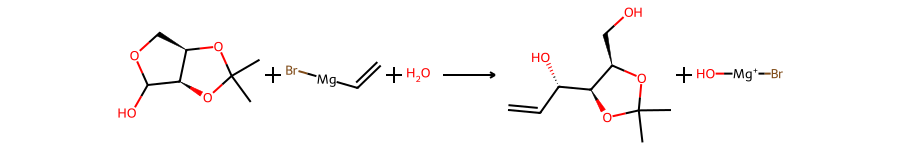

In [12]:
display(Reactions.ReactionFromSmarts(jaworski_171, useSmiles=True))

In [13]:
import pandas as pd
ground_truth = jaworski.copy()
ground_truth = pd.DataFrame(ground_truth)[['R-id', 'reactions']].to_dict(orient='records')

In [18]:
save_database(ground_truth, '../../Data/Validation_set/Jaworski/rule_based_ground_truth.json.gz')

In [14]:
ground_truth[167]['reactions'] = jaworski_167
ground_truth[171]['reactions'] = jaworski_171

In [7]:
ground_truth[167]

{'R-id': 'Jaworski_456',
 'reactions': 'BrBr.CC1=C(C(OC)=O)C=CC=C1[N+]([O-])=O>>O=C(OC)C2=C(CBr)C([N+]([O-])=O)=CC=C2.[HBr]'}

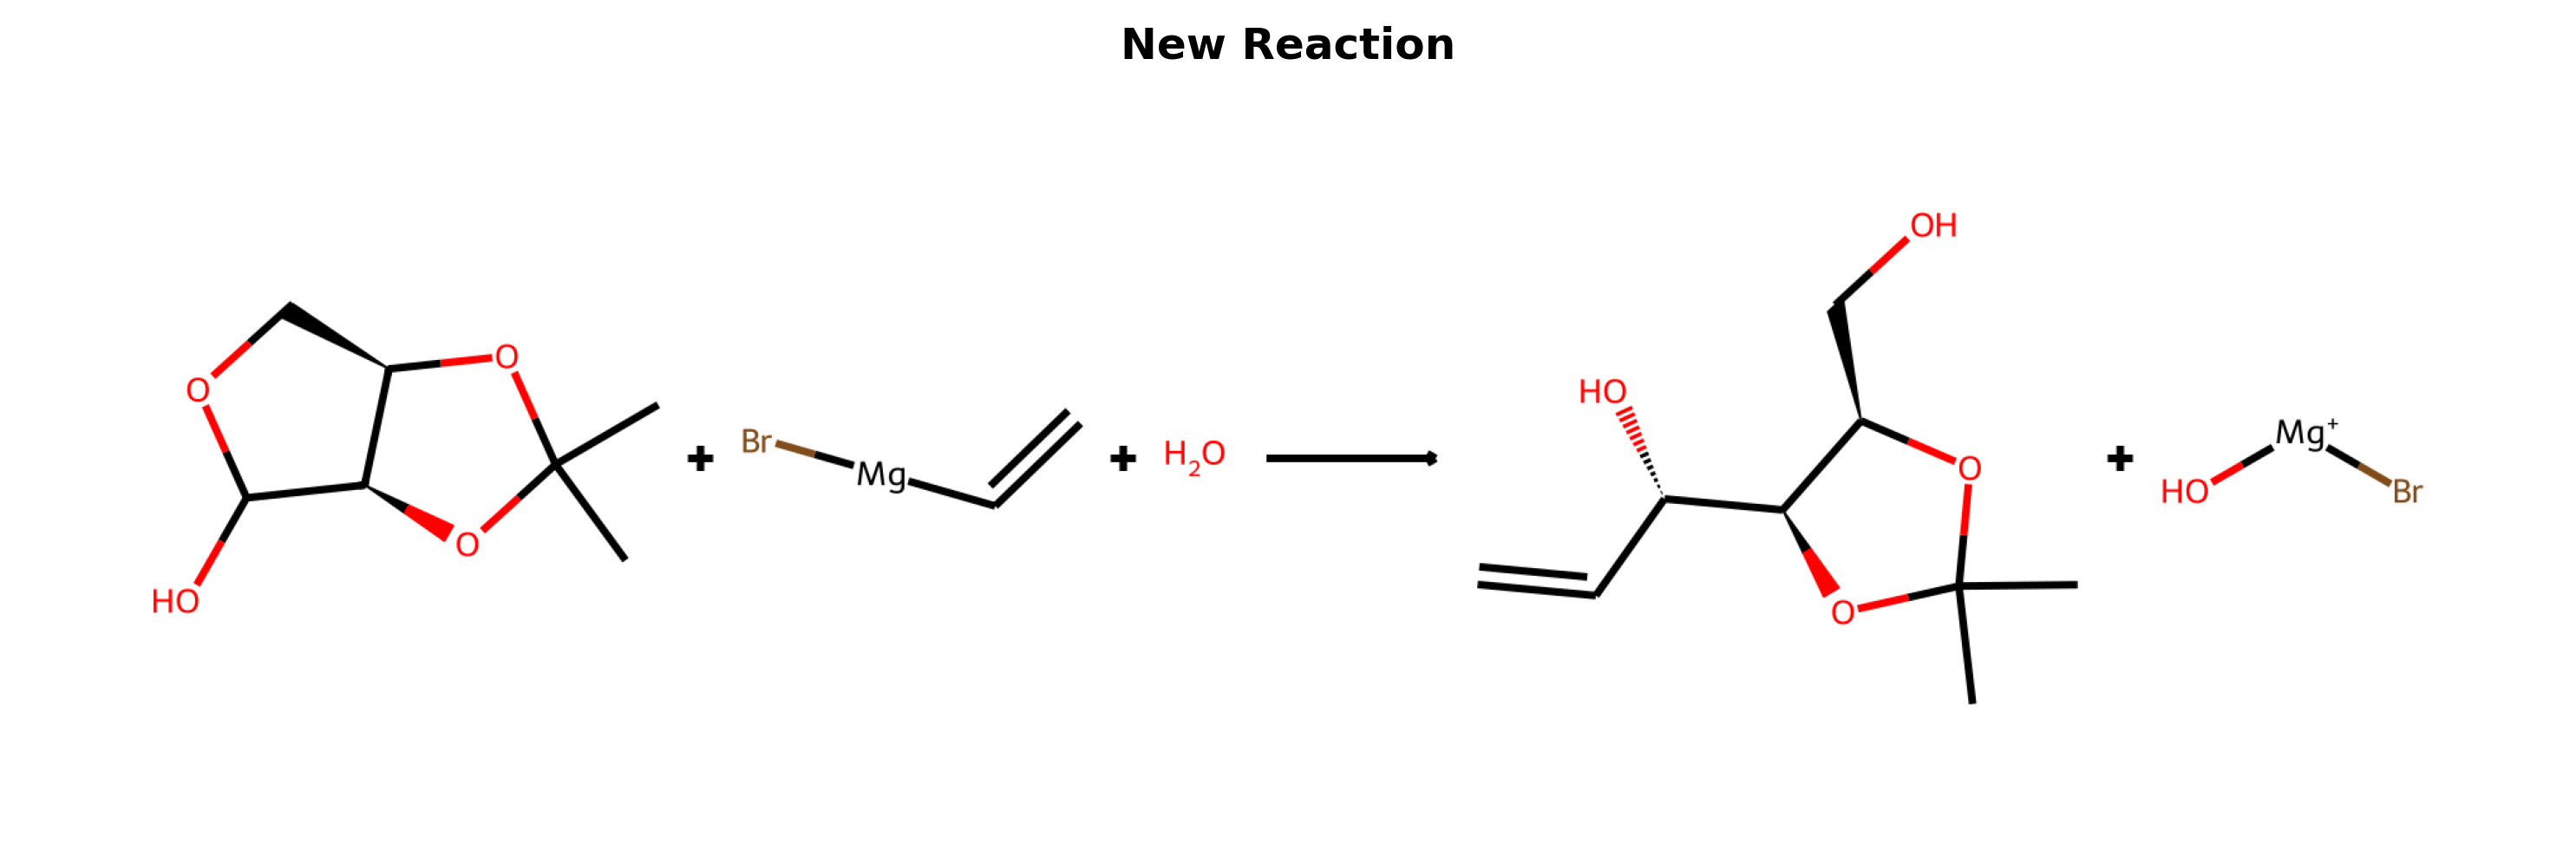

In [16]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
vis.plot_reactions(ground_truth[171], 'reactions', 'reactions', compare=False, show_atom_numbers=False)

In [19]:
# USPTO class
uspto = load_database('../../Data/Validation_set/USPTO_random_class/rule_based_reactions.json.gz')

[16:07:59] WARNING: not removing hydrogen atom without neighbors
[16:07:59] WARNING: not removing hydrogen atom without neighbors


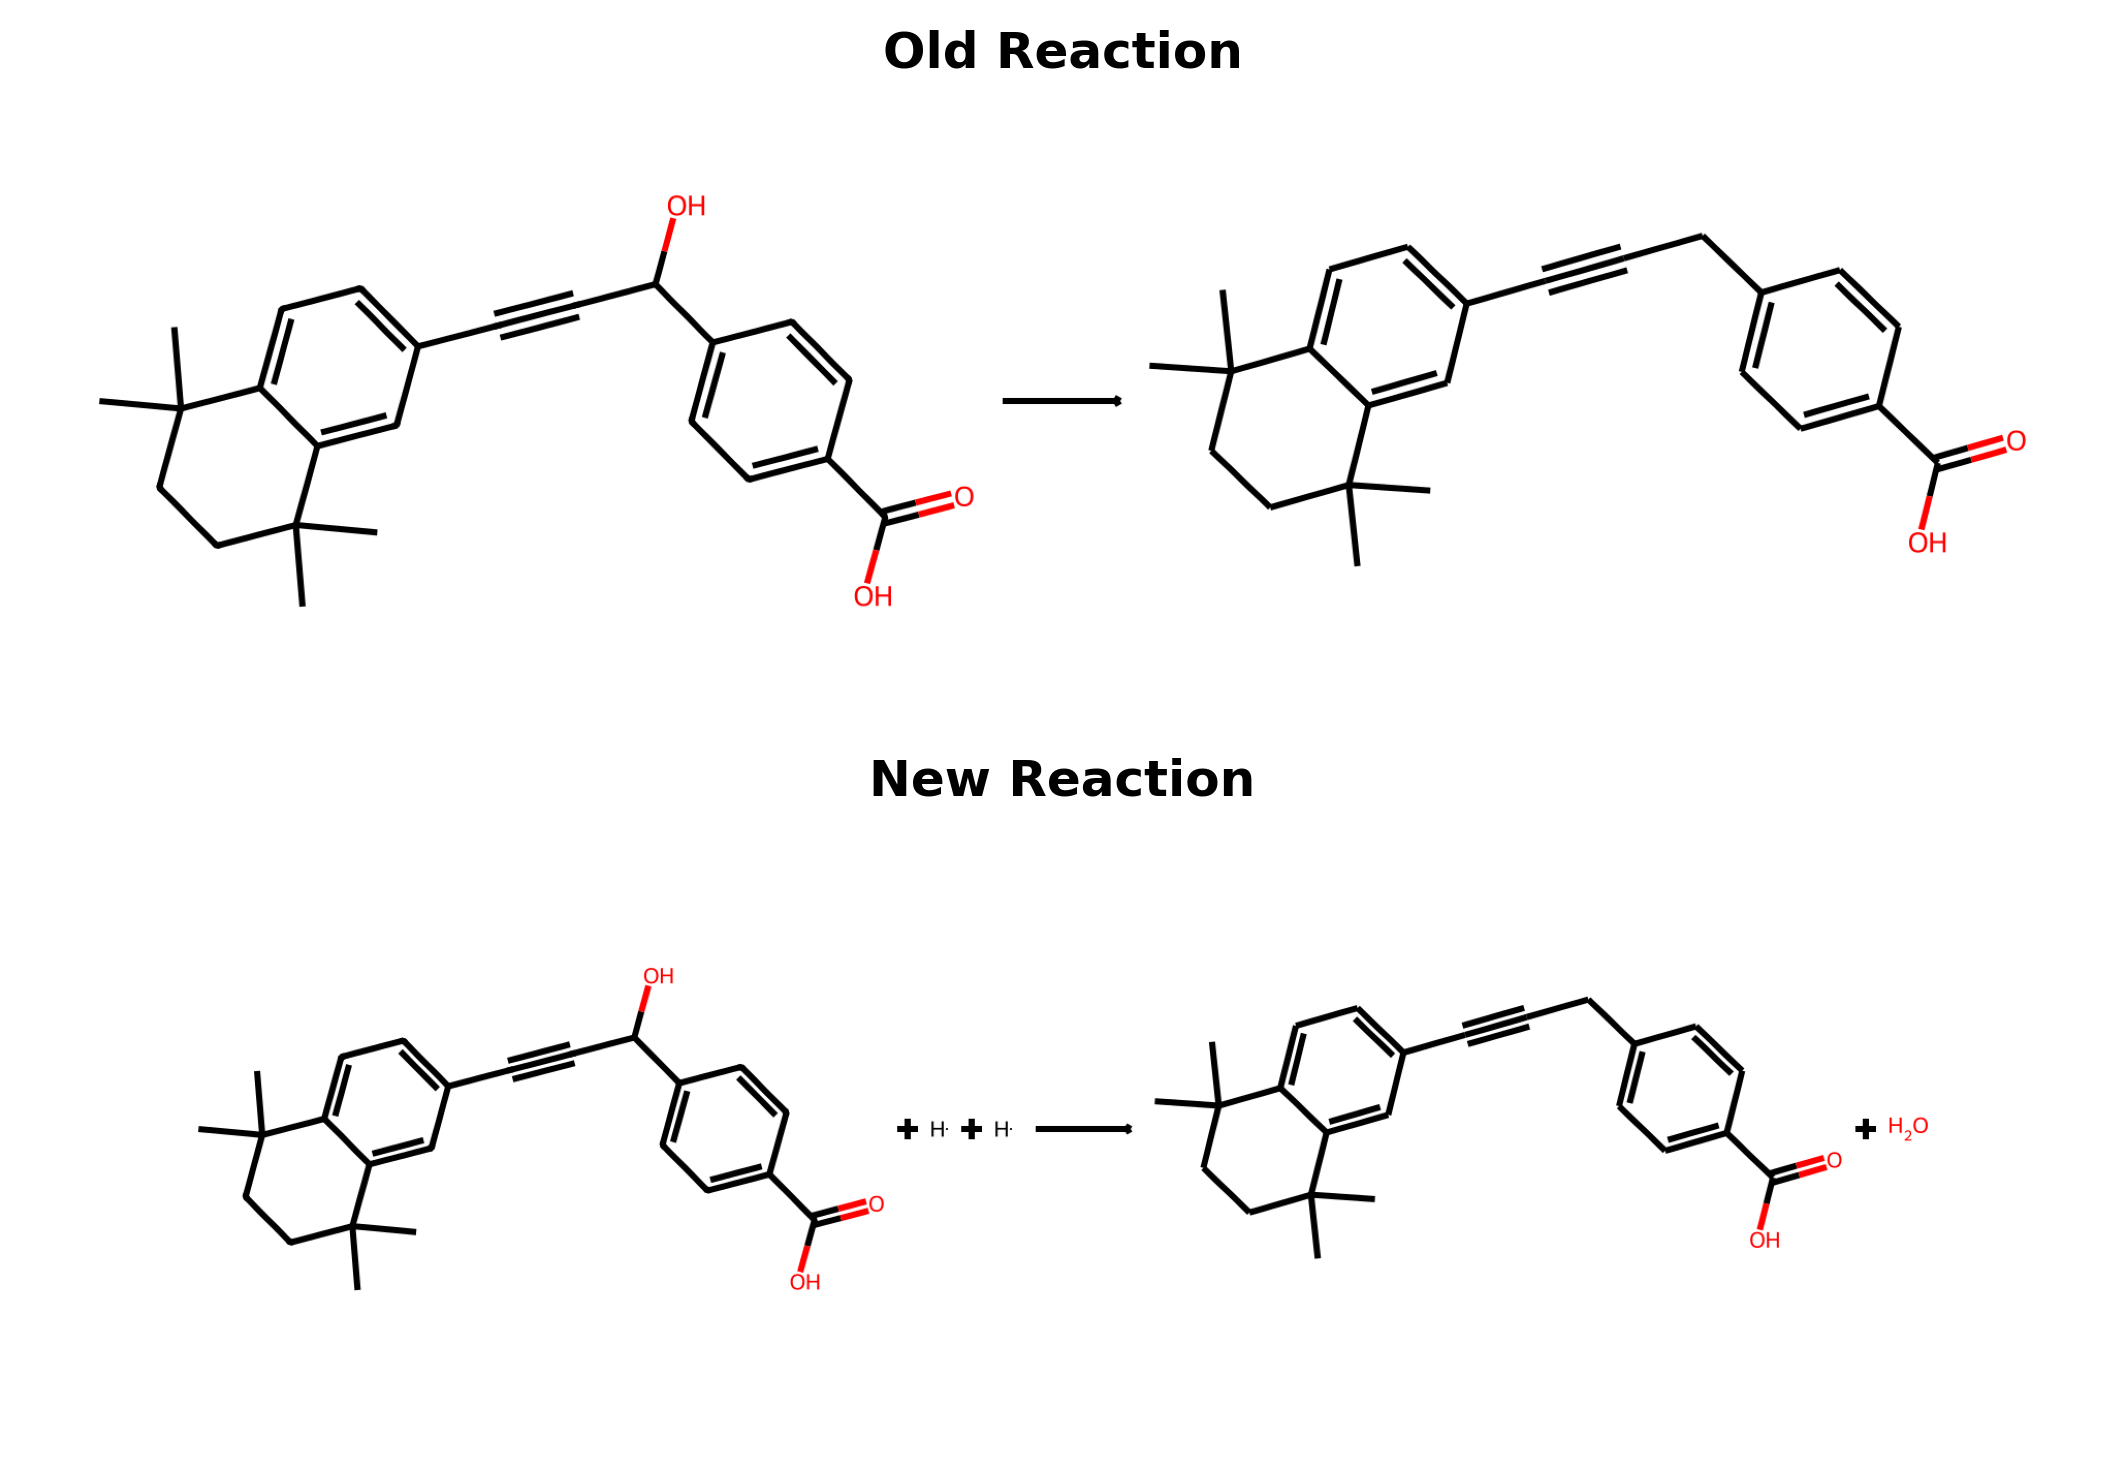

In [20]:
vis.plot_reactions(uspto[176], 'reactions', 'new_reaction', compare=True, show_atom_numbers=False)